In [1]:
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import hydra
from mmda.utils.calibrate import calibrate, get_non_conformity_scores
import seaborn as sns

sns.set_theme()

# Remove the Hydra decorator and modify the function
def load_sim_mat_cali(config_path:str="../config", config_name:str="main")->dict:
    """Load the similarity matrix for calibration."""
    with hydra.initialize(version_base=None, config_path=config_path):
        cfg = hydra.compose(config_name=config_name)
        cfg_dataset = cfg["KITTI"]
        return joblib.load(
            Path(
                cfg_dataset.paths.save_path,
                f"sim_mat_cali_{cfg_dataset.retrieval_dim}_{cfg_dataset.mask_ratio}.pkl",
            )
        )

4606


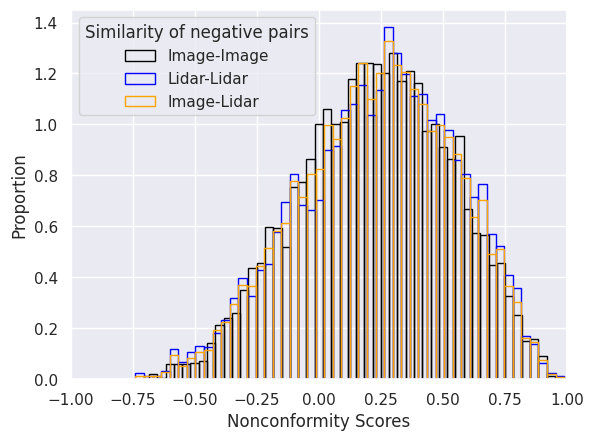

In [2]:
IMAGE, LIDAR, TEXT = 0, 1, 2

data = load_sim_mat_cali()

nc_scores_00, c_scores_00 = get_non_conformity_scores(data, IMAGE, IMAGE)
plt.hist(nc_scores_00, bins=50, fill=None, edgecolor="black", density=True, label="Image-Image")
print(len(nc_scores_00))
nc_scores_11, c_scores_11 = get_non_conformity_scores(data, LIDAR, LIDAR)
plt.hist(nc_scores_11, bins=50, fill=None, edgecolor="blue", density=True, label = "Lidar-Lidar")

nc_scores_12, c_scores_12 = get_non_conformity_scores(data, IMAGE, LIDAR)
plt.hist(nc_scores_12, bins=50, fill=None, edgecolor="orange", density=True, label = "Image-Lidar")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.xlim(-1,1)
plt.legend(title="Similarity of negative pairs")
plt.show()

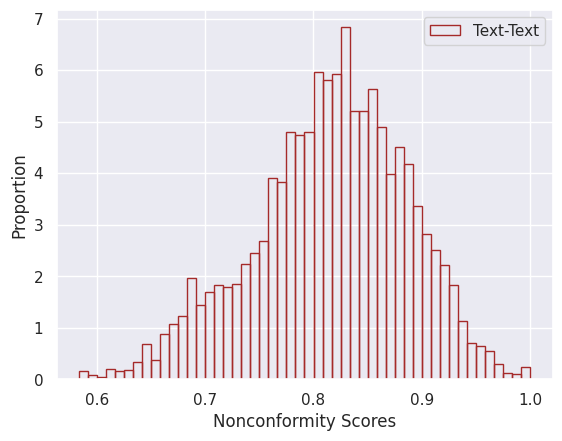

In [3]:
nc_scores_22, c_scores_22= get_non_conformity_scores(data, TEXT, TEXT)
plt.hist(nc_scores_22, bins=50, fill=None, edgecolor="brown", density=True, label = "Text-Text")
plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend(title="Similarity of negative pairs")
plt.legend()

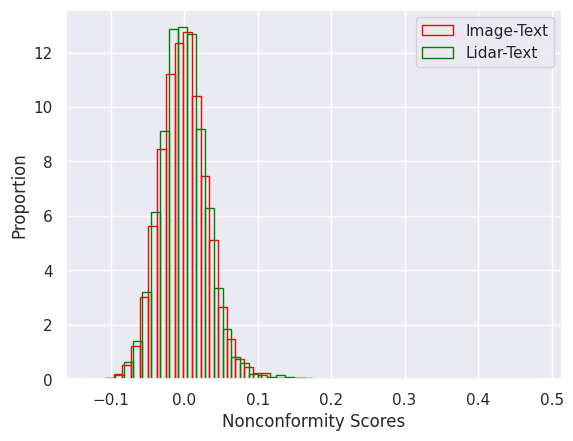

In [4]:
nc_scores_33, c_scores_33 = get_non_conformity_scores(data, IMAGE, TEXT)
plt.hist(nc_scores_33, bins=50, fill=None, edgecolor="red", density=True, label="Image-Text")

nc_scores_44, c_scores_44 = get_non_conformity_scores(data, LIDAR, TEXT)
plt.hist(nc_scores_44, bins=50, fill=None, edgecolor="green", density=True, label="Lidar-Text")

plt.xlabel("Nonconformity Scores")
plt.ylabel("Proportion")
plt.legend()

In [5]:
calibrate(0.75, nc_scores_11)

0.9609205384281372